Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [67]:
import collections
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [68]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [69]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [70]:
# Get the image count for test and train images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [71]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [72]:
## Training dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
  )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [73]:
## Validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
  )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [74]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [75]:
# Create the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123
  )

Found 118 files belonging to 9 classes.


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

In [76]:
# Checking the images and labels shapes
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
      break

(32, 180, 180, 3)
(32,)


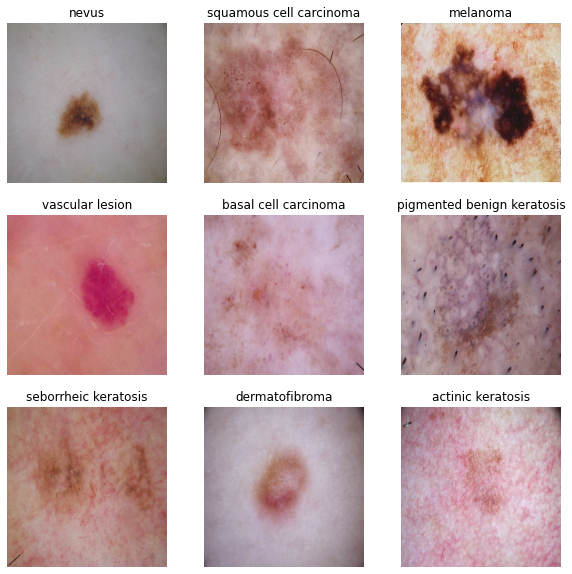

In [121]:
# Visualise one image of each instance of class
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
class_get = []
for images, labels in train_ds.take(1):
    index = 0
    for i in range(31):
        if class_names[labels[i]] not in class_get:
            ax = plt.subplot(3, 3, index + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            class_get.append(class_names[labels[i]])
            index += 1


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [78]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [79]:
### Create a vanilla CNN model
model = Sequential()
model.add(
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
)

model.add(
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal")
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [80]:
### choose an appropirate optimiser and loss function
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [81]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 41, 41, 128)       73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 215168)           

### Train the model

In [82]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
56/56 [==============================] - 22s 103ms/step - loss: 6.5634 - accuracy: 0.2112 - val_loss: 1.9941 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8393 - accuracy: 0.3555 - val_loss: 1.6341 - val_accuracy: 0.4027
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5853 - accuracy: 0.4409 - val_loss: 1.6487 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5786 - accuracy: 0.4527 - val_loss: 1.5811 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3815 - accuracy: 0.5195 - val_loss: 1.4961 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3422 - accuracy: 0.5362 - val_loss: 1.6827 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2795 - accuracy: 0.5507 - val_loss: 1.5327 - val_accuracy: 0.4720
Epoch 8/20


### Visualizing training results

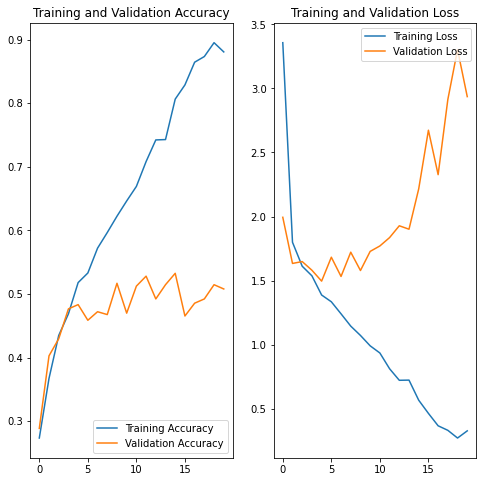

In [83]:
# Visualise Training vs Validation Accuracy/Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [84]:
# Get the model test score
score = model.evaluate(test_ds, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 4s 13ms/step - loss: 7.0157 - accuracy: 0.3305
Test loss: 7.015655040740967
Test accuracy: 0.3305084705352783


### Findings here



*   It seems like the model is highly overfitting based on the above results
*   We are getting an accuract of **90.12%** for Training and an accuracy of **50.78%** for validation.
*   **Training accuracy >> Validation accuracy**, so it is overfitting
*   We will try to avoid the overfitting by adding data augumentation strategy and Dropout layers







In [85]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(
        "horizontal", input_shape=(img_height, img_width, 3)
    ),
    layers.experimental.preprocessing.RandomFlip(
        "vertical", input_shape=(img_height, img_width, 3)
    ),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.3),
  ]
)

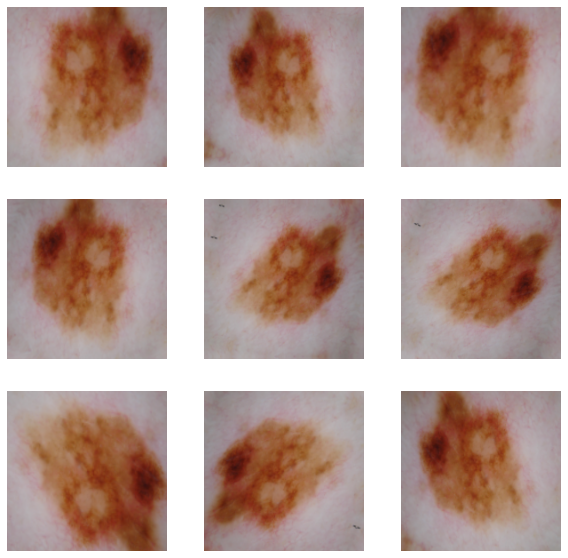

In [86]:
# visualize how your augmentation strategy works for one instance of training image.
# visualise augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()


### Create the model, compile and train the model


In [87]:
## Use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential()
model.add(data_augmentation)
model.add(
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
)

model.add(
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal")
)
model.add(layers.MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(layers.Dropout(0.25))

model.add(
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(9, activation='softmax'))



### Compiling the model

In [88]:
# Compiling the model
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [89]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 43, 43, 64)       

### Training the model

In [90]:
## train  model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
56/56 [==============================] - 3s 34ms/step - loss: 5.9768 - accuracy: 0.1592 - val_loss: 2.0425 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 2.0730 - accuracy: 0.2126 - val_loss: 2.0130 - val_accuracy: 0.2953
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.9222 - accuracy: 0.2611 - val_loss: 1.8912 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.7616 - accuracy: 0.3646 - val_loss: 1.7386 - val_accuracy: 0.4139
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.7331 - accuracy: 0.3792 - val_loss: 1.7702 - val_accuracy: 0.3714
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6273 - accuracy: 0.4459 - val_loss: 1.7344 - val_accuracy: 0.4004
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6133 - accuracy: 0.4454 - val_loss: 1.6440 - val_accuracy: 0.4519
Epoch 8/20
56

### Visualizing the results

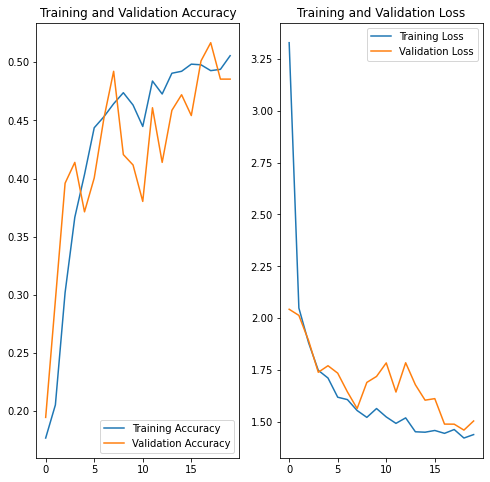

In [91]:
# Visualise the training vs valiation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [92]:
# Get the test score
score = model.evaluate(test_ds, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 4s 12ms/step - loss: 2.3973 - accuracy: 0.3136
Test loss: 2.3973488807678223
Test accuracy: 0.31355932354927063


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


*   We can clearly see that adding proper data augmentation strategy and Dropout layers have prevented the model from overfitting.
*   Now, the accuracy for training is **49.94%** and that of validation dataset is **48.55%**, which is now comparable




#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [93]:
## Get class distribution
def get_class_distribution(dataset):
    """ Function to calculate the class distribution
    """
    class_distribution = {}
    for element in dataset.as_numpy_iterator():
        for label in element[1]:
            if class_names[label] in class_distribution.keys():
                class_distribution[class_names[label]] += 1
            else:
                class_distribution[class_names[label]] = 0

    # sort dict by key
    class_distribution = collections.OrderedDict(sorted(class_distribution.items())) 
    return class_distribution


In [94]:
# Get the full dataset (both train and validation dataset)
full_ds = train_ds.concatenate(val_ds)
# Get the class distribution
train_ds_class_dist = get_class_distribution(full_ds)

In [95]:
# Class distribution in the Train dataset
train_ds_class_dist

OrderedDict([('actinic keratosis', 113),
             ('basal cell carcinoma', 375),
             ('dermatofibroma', 94),
             ('melanoma', 437),
             ('nevus', 356),
             ('pigmented benign keratosis', 461),
             ('seborrheic keratosis', 76),
             ('squamous cell carcinoma', 180),
             ('vascular lesion', 138)])

In [96]:
# Get the class distribution by percentage
def get_class_distribution_percentage(class_dist):
    """ Function to calculate the percentage of class distribution
    """
    total = sum(class_dist.values())
    for key, value in class_dist.items():
        percent = round((value/total) * 100, 2)
        print("{:<30s}:   {} or {}%".format(key, value, percent))

get_class_distribution_percentage(train_ds_class_dist)

actinic keratosis             :   113 or 5.07%
basal cell carcinoma          :   375 or 16.82%
dermatofibroma                :   94 or 4.22%
melanoma                      :   437 or 19.6%
nevus                         :   356 or 15.96%
pigmented benign keratosis    :   461 or 20.67%
seborrheic keratosis          :   76 or 3.41%
squamous cell carcinoma       :   180 or 8.07%
vascular lesion               :   138 or 6.19%


#### Findings: 
#### - Which class has the least number of samples?
Ans: **Seborrheic keratosis** has got the least number of samples. It has got only **76** samples or constitute only **3.41%** percentage compared to the total training samples.

#### - Which classes dominate the data in terms proportionate number of samples?
Ans: **Pigmented benign keratosis** class dominate the data in terms of samples and it constitutes around **20.67%** of overall training samples.
The second and third highest class which dominate the data in these samples are **Melanoma** and **Basal cell carcinoma** which constitutes around **19.6% **and **16.82%** respectively.


####  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [97]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [98]:
path_to_training_dataset= str(data_dir_train) + os.path.sep

import Augmentor
for i in class_names:
    print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50A2109AC8>: 100%|██████████| 500/500 [00:21<00:00, 23.33 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5003FADD30>: 100%|██████████| 500/500 [00:21<00:00, 23.56 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F511C2B6CC0>: 100%|██████████| 500/500 [00:21<00:00, 23.21 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5002EFF240>: 100%|██████████| 500/500 [01:52<00:00,  4.43 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2530x2122 at 0x7F5003F9F0B8>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5003E3CEB8>: 100%|██████████| 500/500 [00:22<00:00, 22.42 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F51244E6A20>: 100%|██████████| 500/500 [00:48<00:00, 10.33 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5001BD5C88>: 100%|██████████| 500/500 [00:21<00:00, 23.17 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5003FBF198>:   0%|          | 1/500 [00:00<00:58,  8.55 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5002F44748>: 100%|██████████| 500/500 [00:22<00:00, 22.70 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [99]:
# Get the total count of images created
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [100]:
# Get the list of all path for newly created images
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_eea7e1d6-3209-422f-8b4c-a76c12a3eb11.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_d21207d0-5955-453f-aad5-e34431a64891.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_d0719699-a4a7-413c-b925-8396f02e076d.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_79c6f6e1-c54f-440b-b01c-1bb824fc6195.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The Internati

In [101]:
# Get the corresponding class name for the newly created images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [102]:
# Create a dict to contain the mappings for the class name along with the path of the image
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [103]:
# Get the list of all path for existing old  images
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0030491.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029025.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029309.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028990.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027884.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026194.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The

In [104]:
# Get the list of all class names corresponding for existing old  images
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list


['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [105]:
# Create the dataframe which contains the image path and the corresponding label for the existing training dataset
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [106]:
# Create the dataframe which contains the image path and the corresponding label for the newly created training dataset
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [107]:
# Get the new class distribution
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [108]:
# Get some of the data from the combined dataframe
new_df

,Path,Label
0,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,actinic keratosis
1,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,actinic keratosis
2,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,actinic keratosis
3,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,actinic keratosis
4,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,actinic keratosis
...,...,...
4495,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,seborrheic keratosis
4496,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,seborrheic keratosis
4497,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,seborrheic keratosis
4498,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,seborrheic keratosis


#### Train the model on the data created using Augmentor

In [109]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [110]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [111]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [112]:
## Create model with normalisation and Dropout layers
model = Sequential()
model.add(
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
)
model.add(
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal")
)
model.add(layers.MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(layers.Dropout(0.25))

model.add(
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(9, activation='softmax'))

#### Compile your model

In [113]:
## Compile the model
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [114]:
# Get the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 43, 43, 64)       

#### Train the model

In [115]:
# Train the model with epochs as 30
epochs = 30
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/30
169/169 [==============================] - 50s 284ms/step - loss: 4.1900 - accuracy: 0.1648 - val_loss: 1.8350 - val_accuracy: 0.2918
Epoch 2/30
169/169 [==============================] - 48s 273ms/step - loss: 1.7919 - accuracy: 0.3255 - val_loss: 1.6346 - val_accuracy: 0.3645
Epoch 3/30
169/169 [==============================] - 47s 273ms/step - loss: 1.5803 - accuracy: 0.3921 - val_loss: 1.4606 - val_accuracy: 0.4692
Epoch 4/30
169/169 [==============================] - 47s 269ms/step - loss: 1.5005 - accuracy: 0.4344 - val_loss: 1.4533 - val_accuracy: 0.4514
Epoch 5/30
169/169 [==============================] - 46s 267ms/step - loss: 1.4382 - accuracy: 0.4648 - val_loss: 1.3505 - val_accuracy: 0.5085
Epoch 6/30
169/169 [==============================] - 46s 265ms/step - loss: 1.3288 - accuracy: 0.5057 - val_loss: 1.2349 - val_accuracy: 0.5598
Epoch 7/30
169/169 [==============================] - 46s 265ms/step - loss: 1.2620 - accuracy: 0.5248 - val_loss: 1.1987 - val_ac

#### **Todo:**  Visualize the model results

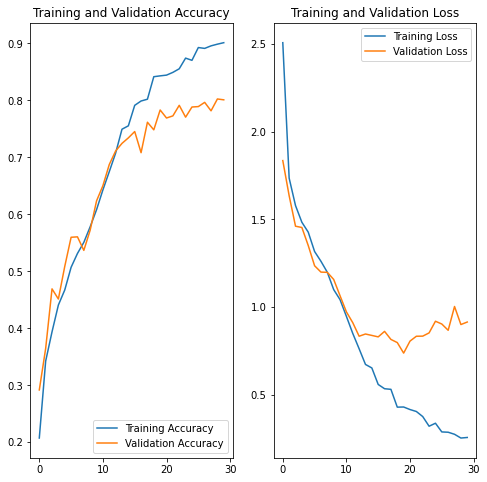

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Yes, the approach of class re-balance has actually improved the overall accuracy for the training and validation dataset, and it has also actually avoid the model being overfitted.
- New Training Accuracy: **89.66%**
- New Validation Accuracy: **80.10%**

Without the use of re-balancing the class, it was around 49.94% for training and that of validation dataset is 48.55%.

Note:
Ran this notebook completely on Google collab. So attaching the same here also with the link.
https://colab.research.google.com/drive/1wMvwHHXRg5FNoiBf4siiDYcGbVkG-aGG?usp=sharing